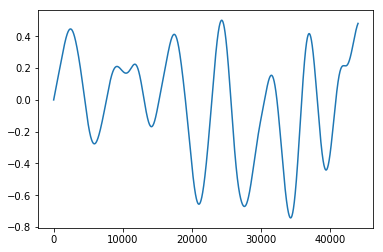

In [243]:
from opensimplex import OpenSimplex
simplex2 = OpenSimplex(seed=2)
out = np.zeros((44100,))
for i in range(len(out)):
    out[i] = simplex2.noise2d(x=i*10/44100, y=i*10/44100)
plt.plot(out)
plt.show()
def simplex1(t):
    return simplex2.noise2d(x=t, y=t)

In [37]:
random()

0.6077780360636319

In [329]:

sampleRate = 44100
time = 0;
timeStep = 1.0 / sampleRate;
alwaysVoice = True;
autoWobble = True;
noiseFreq = 500;
noiseQ = 0.7;
class Glottis():
    def __init__(self):
        self.timeInWaveform = 0
        self.oldFrequency = 140
        self.newFrequency = 140
        self.UIFrequency = 140
        self.smoothFrequency = 140
        self.oldTenseness = 0.6
        self.newTenseness = 0.6
        self.UITenseness = 0.6
        self.totalTime = 0
        self.vibratoAmount = 0.0
        self.vibratoFrequency = 0
        self.intensity = 0
        self.loudness = 1
        self.isTouched = False
        self.touch = 0
        self.x = 240
        self.y = 530
        self.keyboardTop = 500
        self.keyboardLeft = 0
        self.keyboardWidth = 600
        self.keyboardHeight = 100
        self.semitones = 20
        self.marks = [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
        self.baseNote = 87.3071
        self.setupWaveform(0)

    def setupWaveform(self,Lambda):
        self.frequency = self.oldFrequency*(1-Lambda) + self.newFrequency*Lambda;
        tenseness = self.oldTenseness*(1-Lambda) + self.newTenseness*Lambda
        self.Rd = 3*(1-tenseness)
        self.waveformLength = 1.0/self.frequency
        
        Rd = self.Rd
        if (Rd<0.5):
            Rd = 0.5;
        if (Rd>2.7):
            Rd = 2.7;
        Ra = -0.01 + 0.048*Rd;
        Rk = 0.224 + 0.118*Rd;
        Rg = (Rk/4)*(0.5+1.2*Rk)/(0.11*Rd-Ra*(0.5+1.2*Rk))
        Ta = Ra;
        Tp = 1 / (2*Rg)
        Te = Tp + Tp*Rk
        epsilon = 1/Ta;
        shift = np.exp(-epsilon * (1-Te))
        Delta = 1 - shift #divide by this to scale RHS
        RHSIntegral = (1/epsilon)*(shift - 1) + (1-Te)*shift
        totalLowerIntegral = - (Te-Tp)/2 + RHSIntegral
        totalUpperIntegral = -totalLowerIntegral
        omega = math.pi/Tp
        s = math.sin(omega*Te)
        y = -math.pi*s*totalUpperIntegral / (Tp*2)
        z = math.log(y)
        alpha = z/(Tp/2 - Te)
        E0 = -1 / (s*math.exp(alpha*Te))
        self.alpha = alpha;
        self.E0 = E0;
        self.epsilon = epsilon;
        self.shift = shift;
        self.Delta = Delta;
        self.Te=Te;
        self.omega = omega;
    def normalizedLFWaveform(self,t):
        if (t>self.Te):
            output = (-math.exp(-self.epsilon * (t-self.Te)) + self.shift)/self.Delta;
        else:
            output = self.E0 * math.exp(self.alpha*t) * math.sin(self.omega * t);
        return output * self.intensity * self.loudness;
    
    #Glottis
    def runStep(self,Lambda):


        self.timeInWaveform += timeStep;
        self.totalTime += timeStep;
        if (self.timeInWaveform>self.waveformLength):
            self.timeInWaveform -= self.waveformLength;
            self.setupWaveform(Lambda);

        out = self.normalizedLFWaveform(self.timeInWaveform/self.waveformLength);
        
#         aspiration = self.intensity*(1-math.sqrt(self.UITenseness))*\
#                     self.getNoiseModulator();
#         aspiration *= 0.2 + 0.02*random();
#         out += aspiration;
        
        return out
    def finishBlock(self):
        vibrato = 0;
        vibrato += self.vibratoAmount * math.sin(2*math.pi * self.totalTime *self.vibratoFrequency);
#         vibrato += 0.02 * noise.simplex1(self.totalTime * 4.07);
#         vibrato += 0.04 * noise.simplex1(self.totalTime * 2.15);
#         if (autoWobble):
#             vibrato += 0.2 * noise.simplex1(self.totalTime * 0.98);
#             vibrato += 0.4 * noise.simplex1(self.totalTime * 0.5);
        if (self.UIFrequency>self.smoothFrequency):
            self.smoothFrequency = math.min(self.smoothFrequency * 1.1, self.UIFrequency);
        if (self.UIFrequency<self.smoothFrequency):
            self.smoothFrequency = math.max(self.smoothFrequency / 1.1, self.UIFrequency);
        self.oldFrequency = self.newFrequency;
        self.newFrequency = self.smoothFrequency * (1+vibrato);
        self.oldTenseness = self.newTenseness;
        
#         this will add fluctuation to voice , which is more natural
        self.newTenseness = self.UITenseness+ 0.2*simplex1( self.totalTime*3.5 )+\
                                                0.05*simplex1( self.totalTime*4 );

        if ((not self.isTouched) and alwaysVoice):
            self.newTenseness += (3-self.UITenseness)*(1-self.intensity);
        if (self.isTouched or alwaysVoice):
            self.intensity += 0.13;
        else:
            self.intensity -= 0.05;
        self.intensity = np.clip(self.intensity, 0, 1);
    def getNoiseModulator(self):
        voiced = 0.1+0.2*max(0,math.sin(math.pi*2*self.timeInWaveform/self.waveformLength));
        return self.UITenseness* self.intensity * voiced + (1-self.UITenseness* self.intensity ) * 0.3;
    def GT_cache(self,n,block_size):
        GT_cache = np.zeros((n*block_size,))
        
        for j in range(n):
            for i in range(block_size):
                GT_cache[j*block_size+i] = gt.runStep(j/n);
            self.finishBlock(); 
        return GT_cache
gt = Glottis()
print('done')

done


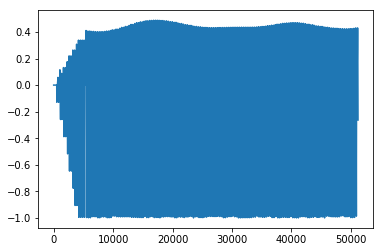

In [330]:
a = gt.GT_cache(100,512)
plt.plot(a)
plt.show()

In [207]:
from random import random

class Tract():

    def __init__(self):
        self.n = 44
        self.bladeStart = 10
        self.tipStart = 32
        self.lipStart = 39
        self.glottalReflection = 0.75
        self.lipReflection = -0.85
        self.lastObstruction = -1
        self.fade = 1.0
        self.movementSpeed = 15 
        self.transients = []
        self.lipOutput = 0
        self.noseOutput = 0
        self.velumTarget = 0.01
        
        self.bladeStart = math.floor(self.bladeStart*self.n/44);
        self.tipStart = math.floor(self.tipStart*self.n/44);
        self.lipStart = math.floor(self.lipStart*self.n/44);
        self.diameter = np.zeros((self.n,));
        self.restDiameter =np.zeros((self.n,));
        self.targetDiameter = np.zeros((self.n,));
        self.newDiameter = np.zeros((self.n,));
        self.fricative_intensity = 1.0
        
        for i in range(self.n):
            diameter = 0;
            if (i<7*self.n/44-0.5):
                diameter = 0.6;  #nearest to glottis
            elif (i<12*self.n/44):
                diameter = 1.1; #2nd nearest
            else:
                diameter = 1.5;
            self.diameter[i] = self.restDiameter[i] = self.targetDiameter[i] = self.newDiameter[i] = diameter;

        self.R =np.zeros((self.n,));
        self.L =np.zeros((self.n,));
        self.reflection =np.zeros((self.n+1,));
        self.newReflection = np.zeros((self.n+1,));
        self.junctionOutputR = np.zeros((self.n+1,));
        self.junctionOutputL = np.zeros((self.n+1,));
        self.A = np.zeros((self.n,));
        self.maxAmplitude = np.zeros((self.n,));


        self.newReflectionLeft = self.newReflectionRight = self.newReflectionNose = 0;
        self.calculateReflections();

    def calculateReflections(self):
        for i in range(self.n):
            self.A[i] = self.diameter[i]*self.diameter[i]; #ignoring PI etc.
        
        for i in range(1,self.n):
            self.reflection[i] = self.newReflection[i];
            if (self.A[i] == 0):
                self.newReflection[i] = 0.999; #to prevent some bad behaviour if 0
            else:
                self.newReflection[i] = (self.A[i-1]-self.A[i]) / (self.A[i-1]+self.A[i]);
        

#         now at junction with nose
        self.reflectionLeft = self.newReflectionLeft;
        self.reflectionRight = self.newReflectionRight;
        self.reflectionNose = self.newReflectionNose;

    def runStep(self,glottalOutput, turbulenceNoise=0,Lambda=0):
        updateAmplitudes = (random()<0.1);
        #mouth
        self.processTransients();


        self.junctionOutputR[0] = self.L[0] * self.glottalReflection + glottalOutput;
        self.junctionOutputL[self.n] = self.R[self.n-1] * self.lipReflection;

        for i in range(1,self.n):
            r = self.reflection[i] * (1-Lambda) + self.newReflection[i]*Lambda;
            w = r * (self.R[i-1] + self.L[i]);
            self.junctionOutputR[i] = self.R[i-1] - w;
            self.junctionOutputL[i] = self.L[i] + w;


        for i in range(self.n):
            self.R[i] = self.junctionOutputR[i]*0.999;
            self.L[i] = self.junctionOutputL[i+1]*0.999;


            if (updateAmplitudes):

                amplitude = abs(self.R[i]+self.L[i]);
                if (amplitude > self.maxAmplitude[i]):
                    self.maxAmplitude[i] = amplitude;
                else:
                    self.maxAmplitude[i] *= 0.999;
    
        self.lipOutput = self.R[self.n-1];


    def processTransients(self):
        for i in range( len(self.transients)):
            trans = self.transients[i];
            amplitude = trans.strength * np.pow(2, -trans.exponent * trans.timeAlive);
            self.R[trans.position] += amplitude/2;
            self.L[trans.position] += amplitude/2;
            trans.timeAlive += 1.0/(sampleRate*2);
        for i in range( len(self.transients)-1,-1,-1):
            trans = self.transients[i];
            if (trans.timeAlive > trans.lifeTime):
                self.transients.splice(i,1)
    def addTurbulenceNoise(self,tubulenceNoise):

#         for i in range(len(UI.touchesWithMouse)):
#             touch = UI.touchesWithMouse[j];
#             if (touch.index<2 or touch.index>Tract.n):
#                 continue;
#             if (touch.diameter<=0):
#                 continue;
#             if (intensity == 0):
#                 continue
    
        intensity = self.fricative_intensity; 
        self.addTurbulenceNoiseAtIndex(0.66*turbulenceNoise*intensity, touch.index, touch.diameter)
    def addTurbulenceNoiseAtIndex(self,turbulenceNoise, index, diamete):
        i = math.floor(index);
        delta = index - i;
        turbulenceNoise *= Glottis.getNoiseModulator();
        thinness0 = np.clip(8*(0.7-diameter),0,1);
        openness = np.clip(30*(diameter-0.3), 0, 1);
        noise0 = turbulenceNoise*(1-delta)*thinness0*openness;
        noise1 = turbulenceNoise*delta*thinness0*openness;
        self.R[i+1] += noise0/2;
        self.L[i+1] += noise0/2;
        self.R[i+2] += noise1/2;
        self.L[i+2] += noise1/2;
    def finishBlock(self):
        self.calculateReflections();
tr =  Tract()
print('done')

done


In [9]:
tr.A

array([0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 1.21, 1.21, 1.21, 1.21,
       1.21, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25,
       2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25,
       2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25])

In [293]:

class AudioSystem():
    def __init__(self):
        self.blockLength = 512,
        self.blockTime = 1,
        self.started = False,
        self.soundOn = False,
        self.blockTime = self.blockLength[0]/float(sampleRate);
        self.outArray = np.zeros(( self.blockLength[0],))
    def doScriptProcessor(self,gt_cache):
#         inputArray1 = np.zeros(( self.blockLength[0],));
        inputArray2 = np.zeros(( self.blockLength[0],));
        
        #inputArray2 = event.inputBuffer.getChannelData(1);
        outArray = np.zeros((self.blockLength[0],))
        for j in range(self.blockLength[0]):
            lambda1 = j/self.blockLength[0];
            lambda2 = (j+0.5)/self.blockLength[0];
#             glottalOutput = gt.runStep(lambda1);
            glottalOutput = gt_cache[j]
            vocalOutput = 0;
            
            # Tract runs at twice the sample rate
            tr.runStep(glottalOutput, inputArray2[j], lambda1);
            vocalOutput += tr.lipOutput + tr.noseOutput;
            
            tr.runStep(glottalOutput, inputArray2[j], lambda2);
            vocalOutput += tr.lipOutput + tr.noseOutput;
            self.outArray[j] = vocalOutput * 0.125;

#             self.outArray[j] = glottalOutput * 0.3;
            
            
#         gt.finishBlock(); 
        tr.finishBlock();
    
fuji = AudioSystem()
print('done')

done


In [113]:
 0.01*np.random.normal( scale=1.0)+0.005*np.random.normal( scale=1.0)


-0.016024467534046953

In [76]:
print(np.random.normal( scale=1.0))

-0.9804716159658536


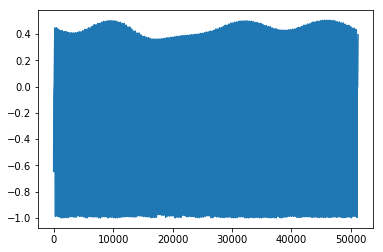

(51200,)


In [337]:
gt_cache =gt.GT_cache(100,512)
plt.plot(gt_cache)
plt.show()
print(gt_cache.shape)

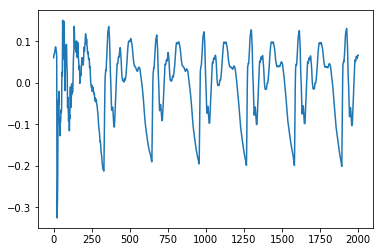

In [338]:
import time
from tqdm import tqdm_notebook as tqdm
n_block = 100
all_w = np.zeros((n_block*512))

# gt.GT_cache(200*fuji.blockLength)
for i in tqdm(range(n_block)):
    fuji.doScriptProcessor(gt_cache[i*512:(i+1)*512])
    all_w[i*512:(i+1)*512] =fuji.outArray
#     print(tr.newReflection)

try:
    plt.plot(all_w[:2000])
except:
    plt.plot(all_w)
plt.show()


# print( tr.lipOutput ,tr.noseOutput)plt.plot(all_w[:2000])

In [339]:
import soundfile as sf
from util import my_util

# sf.write('gt_pulse.wav', all_w, sampleRate)
sf.write('v_pulse.wav', all_w, sampleRate)

# my_util.wavPlayer('./gt_pulse.wav') # load a local WAV file
my_util.wavPlayer('./v_pulse.wav') # load a local WAV file


In [60]:

# tr.runStep(fuji.outArray)
np.random.normal( scale=1.0)


0.9476409034989779

In [120]:
k =  np.zeros((40,));
min(1,2)

1

In [9]:
class A:
    def __init__(self):
        self.foo = 2
    def pName(self):
        self.foo+=1
ob_a = A();
print(ob_a.foo)

class B:
    def __init__(self):
        self.foo = 3
    def pName(self):
        ob_a.pName()

ob_b = B();
ob_b.pName()
print(ob_a.foo)


2
3
